# Visualization Demo

### Gabrielle Hobson

### Contributed to SIO-LMU Visualization Roundtable Group Meeting

### May 14th, 2024

This Jupyter notebook depends on the Python packages `Pyvista, vtk, numpy, matplotlib` and `seissolxdmf`, and for easiest use, it should be run within the Docker container found here at __[SeisSol/Training](https://github.com/SeisSol/Training/tree/main)__. 

### Links to useful examples

A gallery of PyVista examples: https://docs.pyvista.org/version/stable/examples/index.html 

seissolxdmf: https://github.com/SeisSol/Visualization/tree/master/seissolxdmf

In [1]:
import vtk
import pyvista as pv
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import seissolxdmf

In [2]:
# import os
# os.system('/usr/bin/Xvfb :99 -screen 0 1024x768x24 &')
# os.environ['DISPLAY'] = ':99'

In [3]:
import panel as pn
pn.extension('vtk')

### Global pyvista parameters

Maybe you don't want to have to set your font sizes or your background color each time. PyVista lets you set global attributes so that all of your plots can be consistent. 

More info here. https://docs.pyvista.org/version/stable/examples/02-plot/themes#sphx-glr-examples-02-plot-themes-py

In [17]:
pv.global_theme.background = 'white'
pv.global_theme.font.family = 'sans'
pv.global_theme.font.size = 28
pv.global_theme.font.title_size = 28
pv.global_theme.font.label_size = 28
pv.global_theme.font.color = 'black'
# pv.global_theme.font.fmt = '%.6e

Now I can use the code I used to make my original plot (remember the grey background one), but it will follow these global attributes.

In [18]:
pn.extension('vtk')  # this needs to be at the top of each cell for some reason
pl = pv.Plotter(window_size=[3000, 3000])
pl.add_mesh(threshed,scalars='CellQuality')
pl.camera_position = 'xz'
pl.enable_parallel_projection()
pl.show()

ViewInteractiveWidget(height=3000, layout=Layout(height='auto', width='100%'), width=3000)

---

### Using PyVista to plot fault output

Which output would we like to load? I ran TPV13 and it lives one directory up from this notebook. 

In [19]:
fname = "/Users/fkutschera/Documents/Data/Samos/Samos_extracted_lastdt_fault/Ryo_v3_WL_resampled-fault.xdmf"

Code below is adapted from the TPV13 example. 

/Users/fkutschera/anaconda3/envs/work/lib/python3.11/site-packages/pyvista/jupyter/notebook.py:34: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


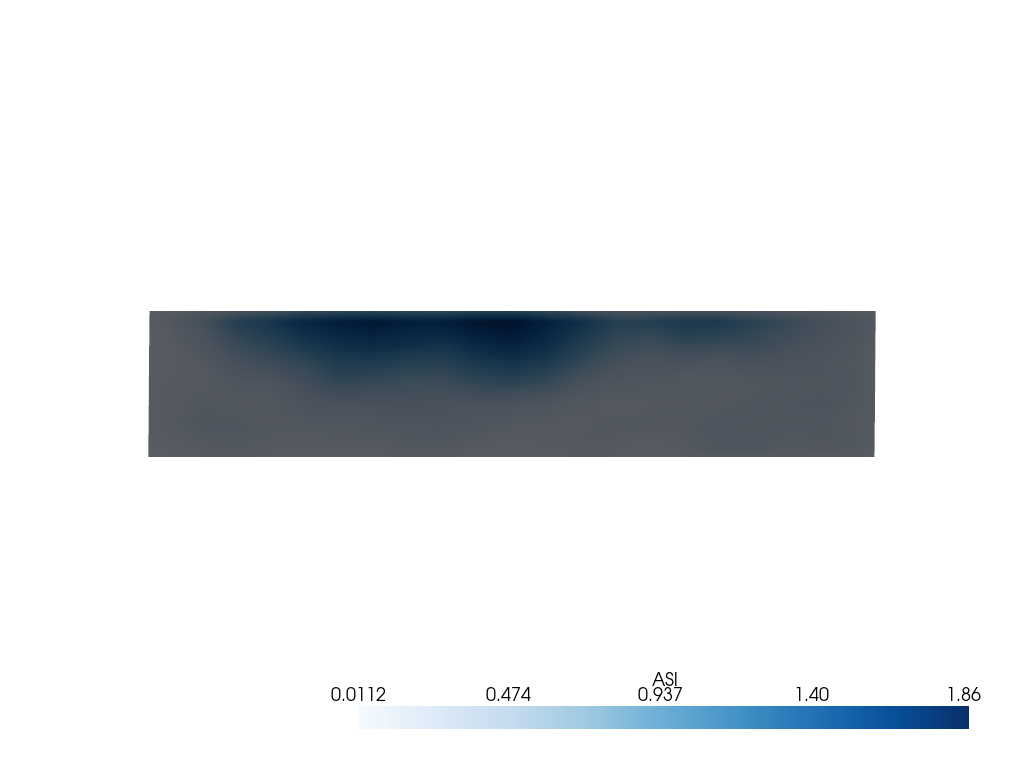

In [20]:
reader = vtk.vtkXdmfReader()
reader.SetFileName(fname)
reader.Update()
cd = reader.GetOutput().GetCellData()
variables = [cd.GetArrayName(i) for i in range(cd.GetNumberOfArrays())]

t = 2
var = "ASl"


reader.UpdateTimeStep(t)
mesh = pv.wrap(reader.GetOutput())

pn.extension('vtk')
pl = pv.Plotter(notebook=True)
pl.add_mesh(mesh, cmap='Blues', scalars=var)
pl.camera_position = 'xz'
pl.enable_parallel_projection()
pl.show()

------

# Using seissolxdmfreader and Matplotlib Triangulations

Maybe we just want to make some straightforward plots with NumPy arrays and Matplotlib.

### Load output from SeisSol TPV13



In [21]:
fname = "/Users/fkutschera/Documents/Data/Samos/Samos_extracted_lastdt_fault/Ryo_v3_WL_resampled-fault.xdmf"

In [22]:
# using the seissolxdmf package and usage example
sx = seissolxdmf.seissolxdmf(fname) 
ndt = sx.ReadNdt() # Read number of time steps
geom = sx.ReadGeometry()  # load geometry array as a numpy array of shape ((nodes, 3))
# load connectivity array as a numpy array of shape ((nElements, 3 or 4))
# The connectivity array gives for each cell a list of vertex ids.
connect = sx.ReadConnect()

Let's check we understand the output we get.

In [23]:
# suppose we load the variable 'ASl', or Accumulated Slip
var = 'ASl'
out = sx.ReadData(var)

print('output is of type:', type(out))
print('output is of shape (ndt, nElements):', out.shape)

output is of type: <class 'numpy.ndarray'>
output is of shape (ndt, nElements): (1, 3125152)


In [49]:
out.ndim

2

In [48]:
# From https://pypi.org/project/seissolxdmf
# Read time step
dt = sx.ReadTimeStep()
# Read number of time steps
ndt = sx.ReadNdt()

NameError: time step could not be determined

### Plotting every output variable at a given timestep

In [51]:
# which timestep?
ts = 1

In [52]:
# create a Triangulation object using the geometry and connectivity arrays from the seissolxdmf reader steps
tri_mesh = tri.Triangulation(geom[:,0], geom[:,2], connect)

# create a list of the outputs
var_list = list(sx.ReadAvailableDataFields()) # returned set is converted to a list

ValueError: z array must have same length as triangulation x and y arrays

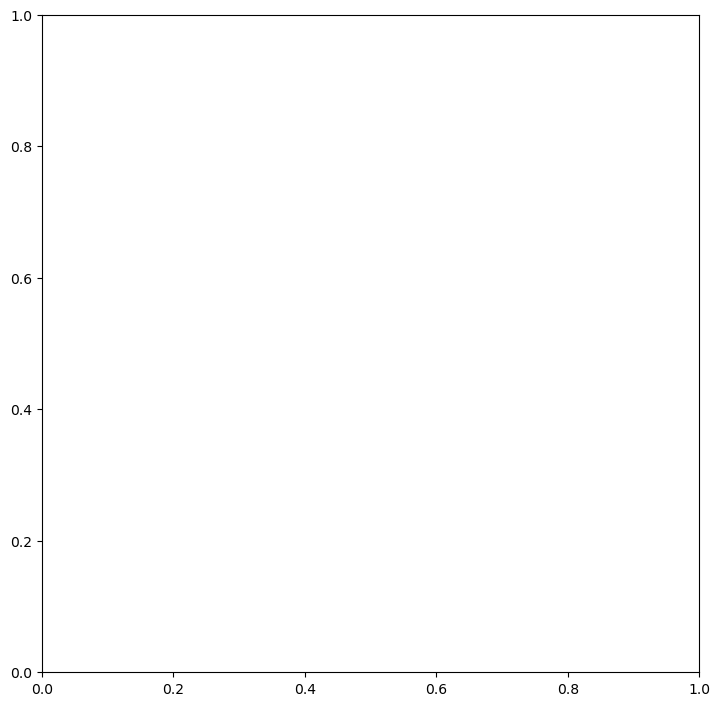

In [53]:
# set up the plot
m,n = int(np.ceil(len(sx.ReadAvailableDataFields()) / 2)), 2
fig = plt.figure(figsize=(30,70))
plt.tight_layout()
fs = 18 # font size 

# loop through each variable and make a subplot for it

for i in range(len(var_list)):
    var = var_list[i]
    assert var in sx.ReadAvailableDataFields() # Check, whether variable var exists in the SeisSol output
    out = sx.ReadData(var) # load SRs as a numpy array of shape ((ndt, nElements))
    #if out.ndim > 1:
    if out.ndim > 2:
        result = out[ts, :]
    else:
        result = out
    out_rep = np.repeat(result,3,axis=0)

    # plotting bit
    ax = fig.add_subplot(m,n,i+1)
    ax.set_aspect('equal')
    cfill = ax.tricontourf(tri_mesh, out_rep, levels=200, cmap='viridis') # core line
    cb = plt.colorbar(cfill, ax=ax, fraction=0.02)
    cb.set_label(label=var, fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    ax.set_xlabel('x (km)', fontsize=fs)
    ax.set_ylabel('z (km)', fontsize=fs)
    ax.set_yticks(fontsize=fs,\
                    ticks=[0,-2000,-4000,-6000,-8000,-10000,-12000],\
                    labels=["0","-2","-4","-6","-8","-10","-12"])
    ax.set_xticks(fontsize=fs,\
                    ticks=[-15000,-10000,-5000,0,5000,10000,15000],\
                    labels=["-15","-10","-5","0","5","10","15"])
    ax.set_title(var,fontsize=fs);

### Plotting one variable over time

In [27]:
import time

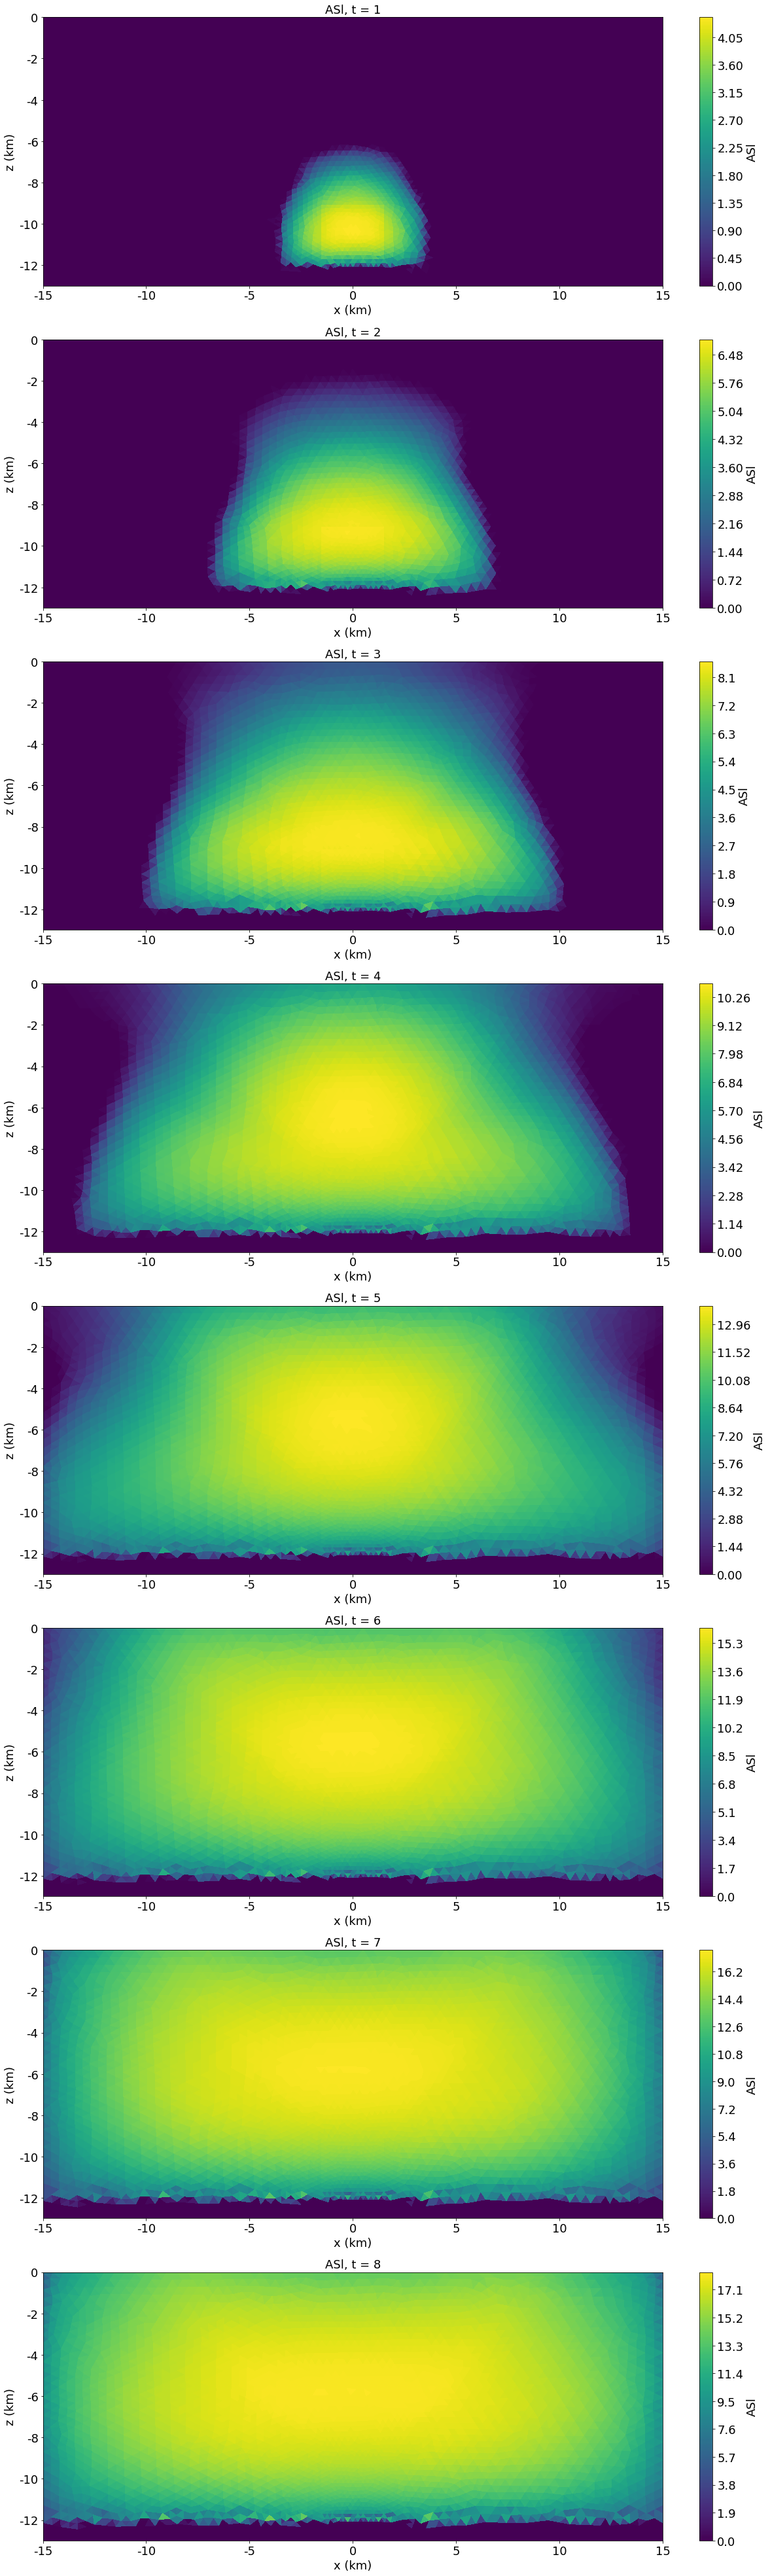

In [28]:
var = 'ASl'

# ndt = sx.ReadNdt()

out = sx.ReadData(var)

fig = plt.figure(figsize=(20,80))
plt.tight_layout()
fs = 18 # font size 
i = 1

for ts in range(1,ndt):
    result = out[ts, :] # slice out time step
    out_rep = np.repeat(result,3,axis=0)
    
    ax = fig.add_subplot(ndt,1,i)
    ax.set_aspect('equal')
    cfill = ax.tricontourf(tri_mesh, out_rep, levels=200, cmap='viridis') # core line
    cb = plt.colorbar(cfill, ax=ax, fraction=0.02)
    cb.set_label(label=var, fontsize=fs)
    cb.ax.tick_params(labelsize=fs)
    ax.set_xlabel('x (km)', fontsize=fs)
    ax.set_ylabel('z (km)', fontsize=fs)
    ax.set_yticks(fontsize=fs,\
                    ticks=[0,-2000,-4000,-6000,-8000,-10000,-12000],\
                    labels=["0","-2","-4","-6","-8","-10","-12"])
    ax.set_xticks(fontsize=fs,\
                    ticks=[-15000,-10000,-5000,0,5000,10000,15000],\
                    labels=["-15","-10","-5","0","5","10","15"])
    ax.set_title(var + ", t = " + str(ts),fontsize=fs);
    i += 1

### Saving figures

One last note, if you want to save any of these figures, you can use:

`plt.savefig("test.png")`

or 

`plt.savefig("test.pdf")`